In [1]:
import os
import sys
import numpy as np
import pandas as pd
from functools import partial
from multiprocessing import Pool
from DataProcessor import createData, createBackTestData
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

/Users/yuxia/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
path = "./stocks data/Data/"
stock_data_filenames = os.listdir(path)

In [3]:
def logi(x_train, x_test, y_train, y_test):
    
    lr = LogisticRegression()
    lr.fit(x_train, y_train)
    accuracy = lr.score(x_test, y_test)
    probs = lr.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label=1)
    area = roc_auc_score(y_test, [tup[1] for tup in probs])
    
    return accuracy, fpr, tpr, area

def randomf(x_train, x_test, y_train, y_test):
    
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train)
    accuracy = rf.score(x_test, y_test)
    probs = rf.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label=1)
    area = roc_auc_score(y_test, [tup[1] for tup in probs])   
    
    return accuracy, fpr, tpr, area

def XGBC(x_train, x_test, y_train, y_test):
    xgbc = xgb.XGBClassifier(max_depth=6, n_estimators=200, learning_rate=0.15)
    xgbc.fit(x_train, y_train)
    accuracy = xgbc.score(x_test, y_test)
    probs = xgbc.predict_proba(x_test)
    fpr, tpr, _ = roc_curve(y_test, probs[:, 1], pos_label=1)
    area = roc_auc_score(y_test, probs[:, 1])
    
    return accuracy, fpr, tpr, area
    
def cal_acurracy(stockname, label_return_period=5, method="Logistic"):
    area = accuracy = 0
    fpr = []
    tpr = []
    path = "./stocks data/Data/" + stockname
    
    try:
        df = pd.read_csv(path)
        data = createData(df, label_return_period=label_return_period, annualized_return=0.1).values
        X = data[:, :-1]
        Y = data[:, -1]
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=18)

        if method == "Logistic":
            accuracy, fpr, tpr, area = logi(x_train, x_test, y_train, y_test)
            
        if method == "RandomForest":
            accuracy, fpr, tpr, area = randomf(x_train, x_test, y_train, y_test)
            
        if method == "xgb":
            accuracy, fpr, tpr, area = XGBC(x_train, x_test, y_train, y_test)

    except:
        print("Error occurs.\nIgnore this stock.")
        
    return accuracy, fpr, tpr, area

def run(file_names, method="Logistic"):
    
    pf = partial(cal_acurracy, method=method)
    p = Pool(processes=10)
    accs = p.map(pf, file_names)
    p.close()
    
    print("Average accuracy: " + str(np.mean([tup[0] for tup in accs])))
    print("Average auc: " + str(np.mean([tup[3] for tup in accs])))

# Example of three different models (with 5 days lag label)

### 1. Logistic regression (All stocks)

In [21]:
run(stock_data_filenames,"Logistic")

Error occurs.
Ignore this stock.
Average accuracy: 0.520409507879
Average auc: 0.508149074123


### 2. RandomForest (All stocks)

In [22]:
run(stock_data_filenames, "RandomForest")

Error occurs.
Ignore this stock.
Average accuracy: 0.696425838929
Average auc: 0.760551967813


### 3. XGBoost (All stocks)

In [23]:
run(stock_data_filenames, "xgb")

Average accuracy: 0.716227776143
Average auc: 0.781647606226


# Performance of models on a random stock

In [4]:
def check_performance(stock_file_name, label_return_period=5):
    path = "./stocks data/Data/" + stock_file_name
    
    df = pd.read_csv(path)
    data = createData(df, label_return_period=label_return_period, annualized_return=0.1).values
    X = data[:, :-1]
    Y = data[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=18)
    accuracy_logi, fpr_logi, tpr_logi, area_logi = logi(x_train, x_test, y_train, y_test)
    accuracy_randomf, fpr_randomf, tpr_randomf, area_randomf = randomf(x_train, x_test, y_train, y_test)
    accuracy_xgb, fpr_xgb, tpr_xgb, area_xgb = XGBC(x_train, x_test, y_train, y_test)

    fig = plt.figure(figsize=(8, 10))
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.xlabel("FPR", size=14)
    plt.ylabel("TPR", size=14)

    plt.plot(fpr_logi, tpr_logi, label="LogisticRegression: {}".format(round(accuracy_logi, 3)))
    plt.plot(fpr_randomf, tpr_randomf, label="RandomForest: {}".format(round(accuracy_randomf, 3)))        
    plt.plot(fpr_xgb, tpr_xgb, label="XGB: {}".format(round(accuracy_xgb, 3)))
    plt.plot([0, 1], [0, 1], c="#000000", label="Diagonal")
    plt.legend()
    plt.title("ROC of " + stock_file_name[:-4] + "(with {} days lag)".format(label_return_period), size=16)
    plt.show()

In [66]:
stock_file_name = stock_data_filenames[int(np.random.random() * len(stock_data_filenames))]

- Performance with labels 1 day lag

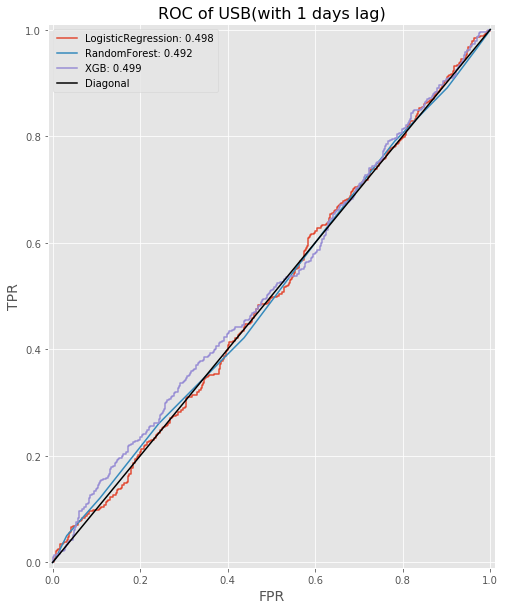

In [7]:
check_performance(stock_file_name, label_return_period=1)

- Performance with labels 2 days lag

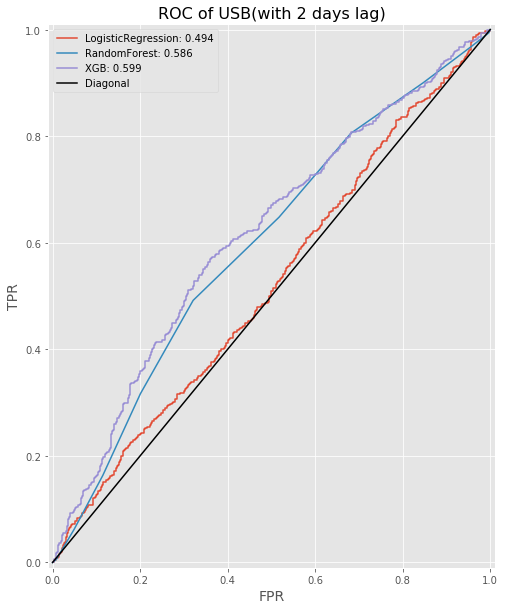

In [8]:
check_performance(stock_file_name, label_return_period=2)

- Performance with labels 5 days lag

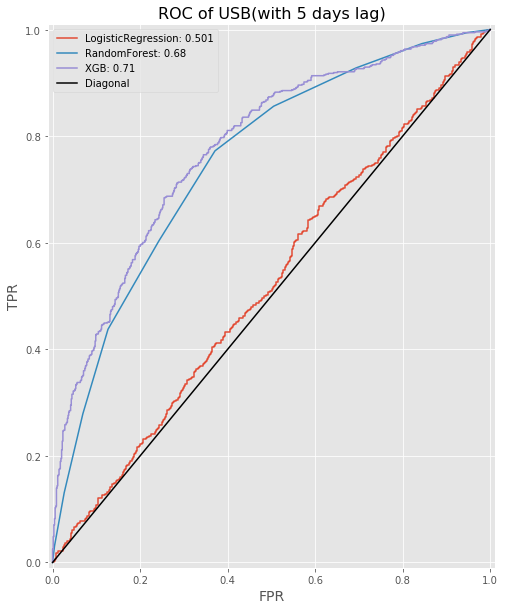

In [10]:
check_performance(stock_file_name, label_return_period=5)

- Performance with labels 10 days lag

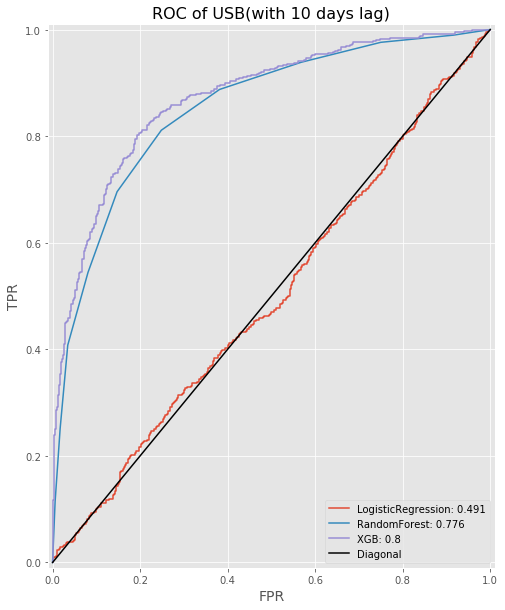

In [11]:
check_performance(stock_file_name, label_return_period=10)

- Performance with label 20 days lag

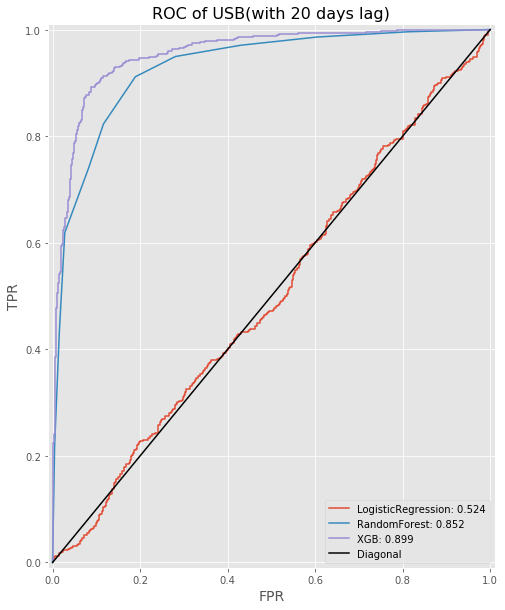

In [12]:
check_performance(stock_file_name, label_return_period=20)

# Back-testing with consideration of transaction costs

In [4]:
stock_file_name = stock_data_filenames[int(np.random.random() * len(stock_data_filenames))]

In [15]:
transaction_fee = 0.003
updateDays = 10
buy = updateDays*[1]
sold = updateDays*[0]

def generate_position(sequence):
    start, end = sequence[0], sequence[1]
    x_train = df_data.iloc[start:end, :-1].values
    y_train = df_data.iloc[start:end, -1].values
    x_pred = df_data.iloc[end, :-1].values    
    xgbc = xgb.XGBClassifier(max_depth=6, n_estimators=200, learning_rate=0.15)
    xgbc.fit(x_train, y_train)
    
    if xgbc.predict(x_pred.reshape(1, -1)):
        return start, buy
    else:
        return start, sold
    
def back_testing(stock_file_name, path=path, label_return_period=updateDays):
    # Load stock's data
    df_raw = pd.read_csv(path + stock_file_name)
    
    global df_data
    df_data = createData(df_raw, label_return_period=label_return_period)
    training_size = int(df_data.shape[0] * 0.8)
    
    # Training model and generate the everyday position
    sequences = [(start, start + training_size) for start in range(0, df_data.shape[0] - training_size, updateDays)]
    p = Pool(processes=20)
    posWithSequence = p.map(generate_position, sequences)
    p.close()
    
    # Processing back test
    positions = []
    backTestData = df_data.iloc[training_size:]
    
    for position in posWithSequence:
        positions.extend(position[1])
    
    positions = positions[:backTestData.shape[0] - 1]
    rets = backTestData.Close.pct_change().dropna()
    
    ## Calculating cumulative returns
    for index, pos in enumerate(positions):
        if index > 0 and index < len(positions) - 1:
            if positions[index - 1] != pos or pos != positions[index + 1]:
                rets.iloc[index] -= transaction_fee
    
    cum_rets = np.cumprod(rets * positions + 1)
    benchmark = np.cumprod(rets + 1)
    
    return backTestData.Close, cum_rets, benchmark

In [16]:
price, cum_rets, benchmark = back_testing(stock_file_name)

In [49]:
def drawReturns(cum_rets, benmark, price):
    fig = plt.figure(figsize=(8, 12))
    
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)
    
    cum_rets.plot(ax=ax1, label="Cumulative Return", legend=True)
    benchmark.plot(ax=ax1, label="BenchMark Return", legend=True)
    ax1.set_title("Cumulative Return VS. BenchMark Return", size=16)
    
    price.plot(ax=ax2)
    ax2.set_title("Stock Price", size=16)
    
    plt.tight_layout()
    plt.legend()
    plt.show()

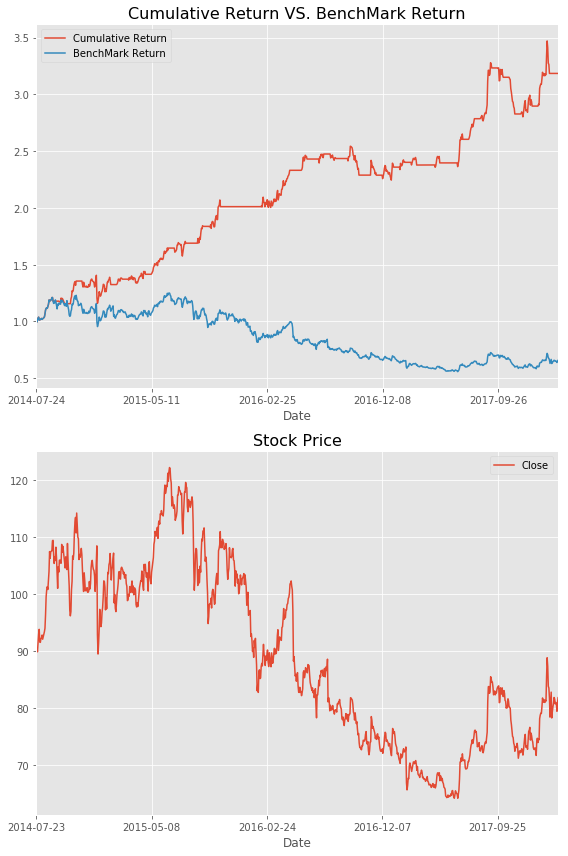

In [50]:
drawReturns(cum_rets, benchmark, price)